 ##### IMPORTS

In [1]:
import dmd_with_power_control_single_task as DMD
import imageio
import numpy as np
import time
from glob import glob
import os
import importlib
importlib.reload(DMD)
import napari as nap

In [2]:
XP_FOLDER = r'D:\Data\PAN\3_target_20240801_111628' # **** D:\Data\G1-2_72F11_ppk\12_mvenus_20240301_172158
TARGET_FOLDER = XP_FOLDER + r'\test' # ***D:\Data\PAN\
GENERAL_PARAMETERS = r'C:\\Users\\Light Sheet User\\Desktop\\DMD_parameters.pickled'
mirrors = DMD.dmd(XP_FOLDER, TARGET_FOLDER, GENERAL_PARAMETERS)
# Prints basic information about the DMD.

Loading library: C:/Program Files/ALP-4.3/ALP-4.3 API/x64/alp4395.dll
DMD found, resolution = 1920 x 1200.
DMD patterns folder already exists.


c:\Users\Light Sheet User\Documents\GitHub\DMD\dmd_with_power_control_single_task.py:43: ResourceWarning: unclosed file <_io.BufferedReader name='C:\\\\Users\\\\Light Sheet User\\\\Desktop\\\\DMD_parameters.pickled'>
  self.parameters = pickle.load(open(general_parameters_folder, 'rb'))


In [3]:
mirrors.project_grid()

In [5]:
mirrors.project(mirrors.grid_mask,  .03)

DMD ON,  input voltage 0.030000 



In [6]:
mirrors.idle()

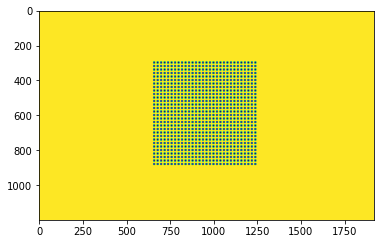

In [5]:
import matplotlib.pyplot as plt
plt.imshow(mirrors.grid_mask)
plt.show()

In [7]:
mirrors.idle()

In [11]:
calibration_image = r'C:\Users\Light Sheet User\Documents\GitHub\DMD\camera_DMD_calibration.png'
mirrors.find_affine_2(calibration_image, show=True)

1115.6 1200.8
[[600 960]
 [600 960]
 [600 960]
 [600 960]
 [600 960]]
[[815 175]
 [507 182]
 [617 539]
 [356 339]
 [283 -31]]


In [8]:
mirrors.close()


DMD halted.
DMD closed.

DND laer off.



In [3]:
image = imageio.imread(r'C:\Users\Light Sheet User\Documents\SiMView Configuration\DMD Images\Letter_R.png')
tot = np.zeros((image.shape), dtype=np.uint8)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22612\3235376734.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(r'C:\Users\Light Sheet User\Documents\SiMView Configuration\DMD Images\Letter_R.png')


In [4]:
mirrors.project(image, 0.1)

DMD ON,  input voltage 0.100000 



In [5]:
mirrors.idle()

In [16]:
mirrors.idle()
mirrors.close()


DMD halted.
DMD closed.

DND laer off.



##### Calibration procedure:

- project the *calibration_mask*;
- save the image through the Labview code;
- run the *find_affine* method.

The affine transorm parameters are saved for future use.

In [6]:
mirrors.project(mirrors.calibration_mask, 1.)

DMD ON,  input voltage 1.000000 



In [7]:
mirrors.idle()

In [10]:
mirrors.parameters['params_folder']

'D:\\DMD_transform_parameters'

Save the calibration image. Usually choosing the same folder as **mirrors.parameters['params_folder']** is a good choice to keep things tidy.
Then plug it in the following method and run it to compute the afffine transform parameters.

c:\Users\Light Sheet User\.conda\envs\light-sheet\lib\site-packages\imageio\plugins\pillow.py:297: UserWarning: Loading 16-bit (uint16) PNG as int32 due to limitations in pillow's PNG decoder. This will be fixed in a future version of pillow which will make this warning dissapear.
  warnings.warn(


1197.0 762.0
626.0 940.0


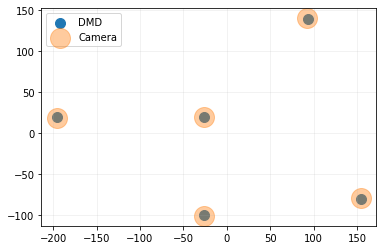

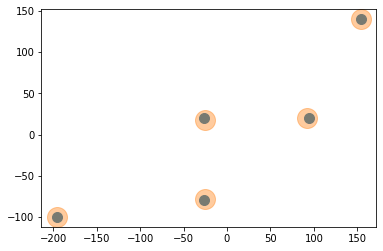

[[ 0.7084092  -0.70580196]
 [ 0.70580196  0.7084092 ]]


In [8]:
calibration_image = \
    r'C:\Users\Light Sheet User\Documents\GitHub\DMD\camera_DMD_calibration.png'
mirrors.find_affine(calibration_image, show=True)

In [12]:
mirrors.close()


DMD halted.
DMD closed.

DND laer off.



In [12]:
on_time = 15
off_time = 45

durations=[on_time, off_time, on_time, off_time,
                           on_time, off_time, on_time, off_time,
                           on_time, off_time, on_time, 60,
                           15, 5, 10, 5, 15, 45, 15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,
                           15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,
                           15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,
                           15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,45,15, 5, 10, 5, 15,60,
                           on_time, off_time, on_time, off_time,
                           on_time, off_time, on_time, off_time,
                           on_time, off_time, on_time, 60,]
tot = 0
for time in durations: tot += time

print(tot/60)

44.416666666666664


In [4]:
from random import shuffle
part = [1,2,3,4]
total_shuf = []
for i in range(4):
    shuffle(part)
    total_shuf += part
    part=[1,2,3, 4]
print(total_shuf)

[2, 4, 3, 1, 2, 1, 3, 4, 4, 2, 1, 3, 4, 3, 1, 2]


#### ROI selection

Use the following method to select ROIs to be stimulated by the DMD.
It is supposed to read rectangular ROIs, where you start drawing from top left corner to bottom right corner of the ROI. Different geometries are not implemented and may result in random or no pattern at all.

In [9]:
mirrors.select_ROIs()

Once the wanted ROIs are drawn, import them within the class. They are stored in order in the "rois" list and saved as .png using the save_dir attribute.

In [10]:
mirrors.import_N_rois(exp='test')

Found 1 ROI(s)


In [13]:
img1 = imageio.imread("D:\\Data\\panDAN_OR_72F11_ppk__george\\excitation_patterns\\test\\mask_1.png")
mirrors.project(img1, 0.5)

DMD ON,  input voltage 0.500000 



C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_24252\4073100696.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread("D:\\Data\\panDAN_OR_72F11_ppk__george\\excitation_patterns\\test\\mask_1.png")


In [16]:
mirrors.idle()

In [15]:
img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
mirrors.project(img1, 0.5)

DMD ON,  input voltage 0.500000 



C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_5008\783320522.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')


In case you plan to project two patterns at the same time, use the method "sum_patterns", passing a list of pattrerns to be summed as numpy matrices. It will return a new matrix that can be used for projection or for a protocol.

Random slopes

In [11]:
masks_path = r'D:\Data\KCs_slopes_fast\excitation_patterns\9_1'


img1 = imageio.imread(masks_path + '\\mask_1.png')
img2 = imageio.imread(masks_path + '\\mask_2.png')
tot = mirrors.sum_patterns([img1, img2])

start = time.time()

mirrors.project_random_slopes_seqence(img2, 1.5, '9_1')

# mirrors.power_titration(tot, 20, 30, 5, 1, [.005, 0.3])

# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\9_1_20240229_113310' # <-- HD:\Data\G1-2_72F11_ppk\
protocol_name = r"/9_1"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

# np.savez(images_folder + protocol_name,\
#          TM=num, images=["1", "dark", "1", "dark", "1", "dark", "1", "dark", 
#                          "1", "dark", "1", "dark", "1", "dark", "1", "dark", 
#                          "1", "dark", "1", "dark", "1", "dark", "1", "dark", 
#                          "1", "dark", "1", "dark", "1", "dark", "1", "dark"
#                          ], \
#                          durations=[10, 50, 10, 50, 10, 50, 10, 50,
#                                     10, 50, 10, 50, 10, 50, 10, 50,
#                                     10, 50, 10, 50, 10, 50, 10, 50,
#                                     10, 50, 10, 50, 10, 50, 10, 50])
np.savetxt(images_folder + protocol_name, [num])


C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_23884\4039362099.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_23884\4039362099.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png')


[1, 2, 4, 3, 3, 1, 2, 4, 4, 3, 1, 2, 2, 1, 4, 3]


In [22]:
np.savetxt(images_folder + protocol_name, [num])

In [10]:
mirrors.idle()

MBONs

In [8]:
masks_path = r'D:\Data\G1-2_72F11_ppk\excitation_patterns\12_1' #


img2 = imageio.imread(masks_path + '\\mask_1.png') # odour1
img1 = imageio.imread(masks_path + '\\mask_2.png') # odour2
img3 = imageio.imread(masks_path + '\\mask_3.png') # pain

tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain
od = mirrors.sum_patterns([img1, img2]) # odour total
# tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain

start = time.time()

power = 2 # changed from 2

on_time = 10
off_time = 50

# start test
mirrors.project(img1, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img3, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)


mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(tot, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)


# end testod
mirrors.project(img1, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img1, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img2, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)




# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\12_2_20240301_175719' # <-- D:\Data\G1-2_72F11_ppk\
protocol_name = r"/12_2"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark", "pun", "dark", "2", "dark",
                         "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark",
                         "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark",
                         "1", "dark", "2", "dark", "1", "dark", "2", "dark", "1", "dark", "2", "dark"
                         ], \
                durations=[10, 50, 10, 50, 10, 50,
                           10, 50, 10, 50, 10, 50, 10, 50,10, 50, 10, 50,10, 50, 10, 50,10, 50, 10, 50,
                           10, 50, 10, 50,10, 50, 10, 50,10, 50, 10, 50,10, 50, 10, 50,10, 50, 10, 50,
                            10, 50, 10, 50, 10, 50, 10, 50, 10, 50, 10, 50]
                ) # 27 mins


C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_10880\1167028650.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_1.png') # odour1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_10880\1167028650.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_2.png') # odour2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_10880\1167028650.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (a

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 



In [12]:
masks_path = r'D:\Data\G1-2_72F11_ppk\excitation_patterns\12_1' #


img1 = imageio.imread(masks_path + '\\mask_1.png') # odour1
img2 = imageio.imread(masks_path + '\\mask_2.png') # odour2
img3 = imageio.imread(masks_path + '\\mask_3.png') # pain

tot = mirrors.sum_patterns([img1, img2, img3]) # odour 1 + pain
od = mirrors.sum_patterns([img1, img2]) # odour total
# tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain

start = time.time()

power = 2 # changed from 2

on_time = 10
off_time = 50

# start test
mirrors.project(img3, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img3, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)
mirrors.project(img3, power)
time.sleep(on_time)
mirrors.idle()
time.sleep(off_time)



# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(tot, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)


# # end testod
# mirrors.project(od, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(od, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)

# mirrors.project(od, power)
# time.sleep(on_time)
# mirrors.idle()
# time.sleep(off_time)




# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\12_5_20240301_184842' # <--D:\Data\G1-2_72F11_ppk\
protocol_name = r"/12_5"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, images=["od", "dark",  "od", "dark", "od", "dark", 
                         "tot", "dark", "tot", "dark", "tot", "dark", "tot", "dark", "tot", "dark", 
                         "tot", "dark", "tot", "dark", "tot", "dark", "tot", "dark", "tot", "dark", "tot", "dark", 
                         "od", "dark", "od", "dark", "od", "dark"
                         ], \
                durations=[10, 50, 10, 50, 10, 50,
                           10, 50, 10, 50, 10, 50, 10, 50,10, 50, 10, 50,10, 50, 10, 50,10, 50, 10, 50, 10, 50,
                            10, 50, 10, 50, 10, 50]
                ) # 17 mins


C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_10880\4289779832.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png') # odour1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_10880\4289779832.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png') # odour2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_10880\4289779832.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (a

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 

DMD ON,  input voltage 2.000000 



MBONS2

In [ ]:
masks_path = r'D:\Data\G1-2_72F11_ppk\excitation_patterns\10_1' #


img2 = imageio.imread(masks_path + '\\mask_1.png') # odour1
img1 = imageio.imread(masks_path + '\\mask_2.png') # odour2
img3 = imageio.imread(masks_path + '\\mask_3.png') # pain

tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain
od = mirrors.sum_patterns([img1, img2]) # odour 1 + pain
# tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain

start = time.time()

power = 2

# start test
mirrors.project(img1, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img3, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)


mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(20)
mirrors.project(img1, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img3, power); time.sleep(10); mirrors.idle(); time.sleep(5)
mirrors.project(img2, power); time.sleep(10); mirrors.idle(); time.sleep(50)

# end test
mirrors.project(img1, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img3, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)




# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\10_2_20240229_133634' # <-- D:\Data\G1-2_72F11_ppk\
protocol_name = r"/10_2"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark", "2", "dark", "pun", "dark",
                         
                         "1", "dark", "pun", "dark", "2", "dark", "1", "dark", "pun", "dark", "2", "dark", "1", "dark", "pun", "dark", "2", "dark", 
                         "1", "dark", "pun", "dark", "2", "dark", "1", "dark", "pun", "dark", "2", "dark", "1", "dark", "pun", "dark", "2", "dark", 
                         "1", "dark", "pun", "dark", "2", "dark", "1", "dark", "pun", "dark", "2", "dark", "1", "dark", "pun", "dark", "2", "dark", 
                         "1", "dark", "pun", "dark", "2", "dark", 

                         "1", "dark", "2", "dark", "pun", "dark"
                         ], \
                durations=[10, 50, 10, 50, 10, 50,
                           10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 20,
                           10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 20,10, 5, 10, 5, 10, 50,
                            10, 50, 10, 50, 10, 50]
                ) # 16 mins

MBONS faster protocol

In [10]:
masks_path = r'D:\Data\panDAN_OR_72F11_ppk__george\excitation_patterns\1_1' #DD:\Data\G1-2_72F11_ppk\7_1_20240225_135629


img1 = imageio.imread(masks_path + '\\mask_1.png') # odour1
img2 = imageio.imread(masks_path + '\\mask_2.png') # odour2


img3 = imageio.imread(masks_path + '\\mask_3.png') # pain
tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain
od = mirrors.sum_patterns([img1, img2]) # odour 1 + pain

start = time.time()

power = 2
stim_duration = 10
dark_time = 30

# start test
mirrors.project(img1, power)
time.sleep(10)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img3, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)


mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(tot, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)


# end testod
mirrors.project(img1, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img2, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)
mirrors.project(img3, power)
time.sleep(stim_duration)
mirrors.idle()
time.sleep(dark_time)




# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\OR83b_ppk72_DAN__1_1_20240415_145920' # <-- D:\Data\G1-2_72F11_ppk\
protocol_name = r"/1_1"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark", "pun", "dark",
                         "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark",
                         "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark",
                         "1", "dark", "pun", "dark"
                         ], \
                durations=[stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, 
                           stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, 
                           stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, 
                           stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, ]
                ) # 26 mins

In [ ]:

# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\7_1_20240225_135629' # <-- D:\Data\G1-2_72F11_ppk\
protocol_name = r"/7_1"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark", "pun", "dark",
                         "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark",
                         "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark", "1pun", "dark", "2", "dark",
                         "1", "dark", "pun", "dark"
                         ], \
                durations=[stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, 
                           stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, 
                           stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, 
                           stim_duration, dark_time, stim_duration, dark_time, stim_duration, dark_time, ]
                ) # 26 mins

In [7]:
#jsut test
masks_path = r'D:\Data\G1-2_72F11_ppk\excitation_patterns\4_1' #D:\Data\G1-2_72F11_ppk\


img1 = imageio.imread(masks_path + '\\mask_1.png') # odour1
img2 = imageio.imread(masks_path + '\\mask_2.png') # odour2
img3 = imageio.imread(masks_path + '\\mask_2.png') # ! WRONG!!!!!
tot = mirrors.sum_patterns([img1, img3]) # odour 1 + pain

start = time.time()

power = 1.5

# just test
mirrors.project(img1, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img1, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img2, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)
mirrors.project(img3, power)
time.sleep(10)
mirrors.idle()
time.sleep(50)




# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\4_2_20240224_120346' # <-- HD: D:\Data\G1-2_72F11_ppk\3_3_20240223_170232
protocol_name = r"/4_2"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark", "2", "dark",
                         "1pun", "dark", "2", "dark", 
                         "pun", "dark"
                         ], \
                durations=[10, 50, 10, 50, 10, 50,
                           10, 50, 10, 50]
                ) # 5 mins

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3236\662420112.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png') # odour1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3236\662420112.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png') # odour2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3236\662420112.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and mak

DMD ON,  input voltage 1.500000 

DMD ON,  input voltage 1.500000 

DMD ON,  input voltage 1.500000 

DMD ON,  input voltage 1.500000 

DMD ON,  input voltage 1.500000 



In [7]:
mirrors.idle()

NEW TITRATION

In [8]:
masks_path = r'D:\Data\Or83b_KC_george_tests\excitation_patterns\3_1' # D:\Data\george_KC_OR_feb_19_2024\KC_1_20240219_171538


img1 = imageio.imread(masks_path + '\\mask_1.png')
img2 = imageio.imread(masks_path + '\\mask_2.png')
# img3 = imageio.imread(masks_path + '\\mask_3.png')
# img4 = imageio.imread(masks_path + '\\mask_4.png')
# img5 = imageio.imread(masks_path + '\\mask_5.png')
# img6 = imageio.imread(masks_path + '\\mask_6.png')
tot = mirrors.sum_patterns([img1, img2])

start = time.time()

mirrors.power_titration(tot, 10, 60, 1, 20, [2, 2.1])
# mirrors.power_titration(img2, 10, 60, 1, 20, [1, 1.1])

# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\\OR83b_KC__george_test__3_1_20240312_154205' # <-- HD: D:\Data\george_KC_OR_feb_20_2024\KC_OR_Titration_1_20240220_144244
protocol_name = r"/3_1"
images_folder = mirrors.xp_folder + current_acquisition 


# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break


np.savez(images_folder + protocol_name,\
         TM=num, 
         images=["1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                 "1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                 "1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                 "1", "dark",  "1", "dark",  "1", "dark", "1", "dark",  "1", "dark", 
                         ], \
                durations=[10, 60, 10, 60, 10, 60, 10, 60, 10, 60,
                           10, 60, 10, 60, 10, 60, 10, 60, 10, 60,
                           10, 60, 10, 60, 10, 60, 10, 60, 10, 60,
                           10, 60, 10, 60, 10, 60, 10, 60, 10, 60])

# np.savez(images_folder + protocol_name,\
#          TM=num, images=["1", "dark",  "1", "dark",  "1", "dark", 
#                          "1", "dark",  "1", "dark",  "1", "dark", 
#                          "1", "dark",  "1", "dark",  "1", "dark", 
#                          "2", "dark",  "2", "dark",  "2", "dark", 
#                          "2", "dark",  "2", "dark",  "2", "dark", 
#                          "2", "dark",  "2", "dark",  "2", "dark", 
#                          "3", "dark",  "3", "dark",  "3", "dark", 
#                          "3", "dark",  "3", "dark",  "3", "dark", 
#                          "3", "dark",  "3", "dark",  "3", "dark", 
#                          "4", "dark",  "4", "dark",  "4", "dark", 
#                          "4", "dark",  "4", "dark",  "4", "dark", 
#                          "4", "dark",  "4", "dark",  "4", "dark", 
                         
#                          ], \
#                          durations=[10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60, 
#                                     10, 60, 10, 60, 10, 60])

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_17868\3097923787.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_17868\3097923787.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png')


Powers: [2.] 

2.0
DMD ON,  input voltage 2.000000 

DMD OFF,  input voltage 0.000000 



KeyboardInterrupt: 

In [7]:
mirrors.idle()

In [12]:
mirrors.idle()

In [12]:
# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break


np.savez(images_folder + protocol_name,\
         TM=num, images=["1", "dark",  "1", "dark",  "1", "dark", 
                         "1", "dark",  "1", "dark", 
                         "2", "dark",  "2", "dark",  "2", "dark", 
                         "2", "dark",  "2", "dark"
                         
                         ], \
                         durations=[10, 60, 10, 60, 10, 60, 
                                    10, 60, 10, 60,
                                    10, 60, 10, 60, 10, 60, 
                                    10, 60, 10, 60])

In [17]:
np.linspace(.02, .02, 1)

array([0.02])

In [8]:
np.savez(images_folder + protocol_name,\
         TM=num, images=["OR1", "dark",  "OR1", "dark",  "OR1", "dark",  "OR1", "dark",  "OR1", "dark",  
                         "OR2", "dark", "OR2", "dark", "OR2", "dark", "OR2", "dark", "OR2", "dark",], \
                         durations=[30, 10, 30, 10, 30, 10, 30, 10, 30, 10, \
                                    30, 10, 30, 10, 30, 10, 30, 10, 30, 10])

In [5]:
masks_path = "D:\\Data\\KC_titration_2\\excitation_patterns\\2_1"


img1 = imageio.imread(masks_path + '\\mask_1.png')
img2 = imageio.imread(masks_path + '\\mask_2.png')

tot = mirrors.sum_patterns([img1, img2])
mirrors.project_square_power(tot, 10, 0.05, 0)
start = time.time()

# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\2_9_20240210_141832' # <-- HERE D:\Data\KC_titration_2\D:\Data\KC_titration_2\
protocol_name = r"/2_9"
images_folder = mirrors.xp_folder + current_acquisition 

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,\
         TM=num, Hz=10)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3572\1460730158.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(masks_path + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3572\1460730158.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(masks_path + '\\mask_2.png')


dmdpowerON


c:\Users\Light Sheet User\anaconda3\envs\LS_2\lib\site-packages\nidaqmx\_library_interpreter.py:6034: DaqWarning: 
Warning 200015 occurred.

While writing to the buffer during a regeneration, the actual data generated might have alternated between old data and new data. That is, while the driver was replacing the old pattern in the buffer with the new pattern, the device might have generated a portion of new data, then a portion of old data, and then a portion of new data again.

Reduce the sample rate, use a larger buffer, or refer to documentation about DAQmx Write for information about other ways to avoid this warning.
  warnings.warn(DaqWarning(error_string, error_code))


DaqError: Specified operation cannot be performed while the task is running.
Task Name: power

Status Code: -200479

In [6]:
mirrors.idle()

##### SUM protocol

In [11]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'/9_2_20231027_160538' # <-- HERE: D:\Data\ramp\
protocol_name = r"/9_1"
images_folder = mirrors.xp_folder + current_acquisition 

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')
img3 = imageio.imread(mirrors.save_dir + '\\mask_3.png')

img12 = mirrors.sum_patterns([img1, img2]) # the sum
img13 = mirrors.sum_patterns([img1, img3])
img23 = mirrors.sum_patterns([img2, img3])
img123 = mirrors.sum_patterns([img1, img2, img3])

img_seq = [img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, img12, img123, img23, img3, mirrors.dark,
           img1, img12, img123, img23, img3, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark,
           img1, mirrors.dark, img3, mirrors.dark, img2, mirrors.dark
           ]
img_seq_names = ['1', 'd', '3', 'd', '2', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', '12', '123', '23', '3', 'd',
                 '1', '12', '123', '23', '3', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', 'd', '3', 'd','2', 'd',
                 '1', 'd', '3', 'd','2', 'd'
                ]
img_times = [10, 30, 10, 30, 10, 30,
             10, 30, 10, 30,10, 30,
             10, 30, 10, 30,10, 30,
             10, 10, 10, 10, 10, 60,
             10, 10, 10, 10, 10, 60,
             10, 30, 10, 30,10, 30,
             10, 30, 10, 30,10, 30,
             10, 30, 10, 30, 10, 30
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22100\3663936598.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22100\3663936598.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22100\3663936598.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and mak

In [15]:
mirrors.idle()

In [13]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'/test_filter_1_b__20231113_143548' # <-- HERE D:\Data\learning\
protocol_name = r"/tst_filter_1_b"
images_folder = mirrors.xp_folder + current_acquisition

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')

img_seq = [img1, mirrors.dark
           ]
img_seq_names = ['1', 'd'
                ]
img_times = [20, 20
             ]

reps = 5 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break

np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_21064\613735808.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')


In [12]:
mirrors.project(img1)

In [22]:
mirrors.idle()

In [10]:
mirrors.close()


DMD halted.
DMD closed.



#### Andre protocol

In [23]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\5_2_20230926_165438' # <-- HERED:\Data\Or83b_KC__rGeeco_ChronomVenus\5_2_20230926_165438
protocol_name = r"/5_2"
images_folder = mirrors.xp_folder + current_acquisition 

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')


img_seq = [img1, img2, img1, img2, img1, img2, mirrors.dark,
           img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, img1,mirrors.dark, img1,mirrors.dark,  img1, mirrors.dark,
            img1, img2, img1, img2, img1, img2, mirrors.dark ]
img_seq_names = ['1','2', '1','2', '1','2', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                 '1','2', '1','2', '1','2', 'dark'
                 ]
img_times = [30, 30, 30, 30, 30, 30, 60,
             30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,30, 10,
             30, 30, 30, 30, 30, 30, 60,]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3744\1653027485.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_3744\1653027485.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')


#### Andre protocol (OLD)

In [ ]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\5_1_20231215_115231' # <-- HERED:\Data\Or83b_KC__rGeeco_ChronomVenus\5_2_20230926_165438
protocol_name = r"/5_1"
images_folder = mirrors.xp_folder + current_acquisition 

img1 = imageio.imread(mirrors.save_dir + '\\mask_1.png')
img2 = imageio.imread(mirrors.save_dir + '\\mask_2.png')


img_seq = [img1, mirrors.dark, img2,mirrors.dark, img1,mirrors.dark,
            img2, mirrors.dark, img1,mirrors.dark, img2, mirrors.dark, # test

           img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark, img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, img1,mirrors.dark, img1,mirrors.dark,  img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, img1,mirrors.dark, img1,mirrors.dark,  img1, mirrors.dark,
           img1,  mirrors.dark, img1,mirrors.dark, 
           
            img1, mirrors.dark, img2,mirrors.dark, img1,mirrors.dark,
            img2, mirrors.dark, img1,mirrors.dark, img2, mirrors.dark] #test again

img_seq_names = ['1', 'dark','2', 'dark', '1', 'dark','2', 'dark', '1', 'dark','2', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                 '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                  '1', 'dark','1', 'dark','1', 'dark','1', 'dark','1', 'dark',
                   '1', 'dark','1', 'dark',
                 '1', 'dark','2', 'dark', '1', 'dark','2', 'dark', '1', 'dark','2', 'dark'
                 ]
img_times = [10, 20, 10, 20, 10, 20, 10, 20, 10, 20, 10, 60,
             10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15,
             10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 15, 10, 120, # 17 times 
             10, 20, 10, 20, 10, 20, 10, 20, 10, 20, 10, 60]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

### MBON trainig protocol

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
current_acquisition = r'\1_1_20231030_105408' # <-- HEREDD:\Data\learning\
protocol_name = r"/1_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',
                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',
                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',
                 '1', 'dark', 'p', 'dark', '1', 'dark', 'p', 'dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                 ]
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 60, 20, 5, 20, 60,
             20, 5, 20, 60, 20, 5, 20, 60,
             20, 5, 20, 60, 20, 5, 20, 60,
             20, 5, 20, 60, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_20820\2777809818.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_20820\2777809818.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_20820\2777809818.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current

KeyboardInterrupt: 

SAM PROTOCOL WITH 2 ODOURS (30.3 mins)

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\2_1_20231115_150631' # <-- HERE D:\Data\lear
protocol_name = r"/2_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_25436\3812522150.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_25436\3812522150.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_25436\3812522150.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current

Sam's protocol (LONGER)

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\9_1_20231207_115657' # <-- D:\Data\57C10__Or83b_ppk__jRGECO_iRFP__
protocol_name = r"/9_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark, od1, mirrors.dark, pun, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark','2','dark', '1', 'dark', 'p', 'dark','2','dark',
                 '1', 'dark', 'p', 'dark', '2','dark','1', 'dark', 'p', 'dark','2','dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_26988\4089100158.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_26988\4089100158.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_26988\4089100158.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current

SAME TIME (Hadi's, 21mins)

In [6]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\2_2_20231212_113818' # <-- HERE VD:\D:\DataurPostTest\2\
protocol_name = r"/2_2"
images_folder = mirrors.xp_folder + current_acquisition

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment
sum = mirrors.sum_patterns([od1, pun])

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22436\111115180.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22436\111115180.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
C:\Users\Light Sheet User\AppData\Local\Temp\ipykernel_22436\111115180.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current be

In [8]:
img_times = [
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]
tot = 0
for t in img_times:
    tot +=t
print(tot/60)

21.333333333333332


Same time and FASTER (16 mins total)

In [ ]:
# The path to the current acquisition folder is needed in order to save the sequence of projections.
import time
current_acquisition = r'\8_1_20231206_112827' # <-- HERE D:\Data\57C10__Or83b_ppk__jRGECO_iRFP__ChronosmVenus__ChronosmVenus_repo-GFP\3xOdourTest_24xOdour+ppk_3xOdourPostTest\6\
protocol_name = r"/8_1"
images_folder = mirrors.xp_folder + current_acquisition 

od1 = imageio.imread(mirrors.save_dir + '\\mask_1.png') # odour_1
od2 = imageio.imread(mirrors.save_dir + '\\mask_2.png') # odour_2
pun = imageio.imread(mirrors.save_dir + '\\mask_3.png') # punishment
sum = mirrors.sum_patterns([od1, pun])

img_seq = [
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,

           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,
           sum, mirrors.dark, od2, mirrors.dark,

           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark,
           od1, mirrors.dark, od2, mirrors.dark
           ]
img_seq_names = [
                '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark',

                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',
                 '1andP', 'dark', '2', 'dark',

                 '1','dark', '2','dark',
                 '1','dark', '2','dark',
                 '1','dark', '2','dark'
                  ]
img_times = [
             10, 45, 10, 45,
             10, 45, 10, 45,
             10, 45, 10, 45,

             10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 
             10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 
             
             10, 45, 10, 45,
             10, 45, 10, 45,
             10, 45, 10, 45
             ]

reps = 1 # whole sequence repetition
start = time.time()
mirrors.sequence_of_single_images(img_seq, img_times, reps)
mirrors.idle()

# SAVE THE PROTOCOL
filenames_camera_0 = r'\SPC00_TM*_ANG000_CM0_CHN00_PH0.stack'
all_volumes = sorted(glob(images_folder + filenames_camera_0))
for num, volume in enumerate(all_volumes):
    current = os.path.getctime(volume)
    if current - start > 0:
        break
np.savez(images_folder + protocol_name,
         TM=num, images=img_seq_names, durations=img_times)

In [7]:
img_times = [
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5, 20, 5,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]

tot = 0
for time in img_times:
    tot += time

print(tot/60)

21.333333333333332


In [3]:
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]
tot = 0
for time in img_times:
    tot += time
print(tot/60)

65.0


In [8]:
img_times = [
            20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45,

             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             20, 5, 20, 5, 20, 60, 20, 5, 20, 5, 20, 60,
             
             20, 45, 20, 45,
             20, 45, 20, 45,
             20, 45, 20, 45
             ]
tot = 0
for time in img_times:
    tot+= time
tot/60

30.333333333333332

In [9]:
# how to read the dmd triggers file
a = np.load(images_folder + "triggers_numpy.npz")
lst = a.files
for item in lst:
    print(item)
    print(a[item])

TM
558
images
['od1' 'dark' 'od2' 'dark' 'od3' 'dark' 'od4' 'dark' 'od3' 'dark' 'od1'
 'dark']
durations
[5 5 5 5 5 5 5 5 5 5 5 5]


### Close the DMD when done.

In [16]:
mirrors.close()


DMD halted.
DMD closed.



In [16]:
import numpy as np
a = np.load(r'D:\Data\KC_speed_tests\1_1_20240216_142207\1_1.npz')
lst = a.files
for item in lst:
    print(item)
    print(a[item])

TM
94
images
['1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1'
 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark' '1' 'dark'
 '1' 'dark' '1' 'dark' '1' 'dark']
durations
[10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50 10 50
 10 50 10 50 10 50 10 50]
